In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

pd.set_option('display.max_columns', 90)
pd.options.mode.chained_assignment = None
pd.options.mode.copy_on_write = True

In [24]:
movies = pd.read_csv('../data/imdb-cleaned.csv')

# Data Preparation

In [25]:
movies['total_votes'] = movies.loc[:, 'rating_1':'rating_10'].sum(axis='columns')

We made a variable `total_votes` with the total number of user votes on each movie.

In [26]:
def calc_unweighted_rating(row):
    return sum([i * row[f'rating_{i}'] for i in range(1, 11)]) / row['total_votes']

movies['unweighted_rating'] = movies.apply(calc_unweighted_rating, axis='columns')

In [27]:
def calc_polarization(row):
    total_score = 0
    for rating_1 in range(1, 11):
        for rating_2 in range(rating_1 + 1, 11):
            total_score += row[f'rating_{rating_1}'] / row['total_votes'] * row[f'rating_{rating_2}'] / row['total_votes'] * (rating_2 - rating_1)

    return total_score

In [28]:
movies['polarization_score'] = movies.apply(calc_polarization, axis='columns')

We made a variable `polarization_score` with the polarization score for each movie's ratings calculated using Esteban and Ray's algorithm.

In [29]:
def calc_country_rating(country_idx, row):
    total_rating = 0
    total_votes = 0
    for rating in range(1, 11):
        total_rating += rating * row[f'country_{country_idx}_rating_{rating}']
        total_votes += row[f'country_{country_idx}_rating_{rating}']
    return total_rating / total_votes

In [30]:
for i in range(5):
    movies[f'country_{i}_rating'] = movies.apply(lambda row: calc_country_rating(i, row), axis='columns')

We made variables `country_{0...4}_rating` with the average rating for each of the top five countries with the most votes for each movie.

In [31]:
def calc_ptp(row):
    ptp = np.ptp(row.loc['country_0_rating':'country_4_rating'])

    max_country_idx = np.argmax(row.loc['country_0_rating':'country_4_rating'])
    min_country_idx = np.argmin(row.loc['country_0_rating':'country_4_rating'])
    max_country = row[f'country_{max_country_idx}']
    min_country = row[f'country_{min_country_idx}']

    return pd.Series([ptp, max_country, min_country])

In [32]:
movies[['country_ptp', 'max_country_ptp', 'min_country_ptp']] = movies.apply(calc_ptp, axis='columns')

We made a variable `country_ptp` with the difference between the highest and lowest average ratings between the top five countries with the most votes for each movie. The variables `max_country_ptp` and `min_country_ptp` record the country codes of the two countries with the highest and lowest average ratings for each movie, respectively.

In [33]:
movies['rating_diff'] = movies['weighted_rating'] - movies['unweighted_rating']

We made a variable `rating_diff` with the difference between the weighted (by IMDb) rating and the unweighted rating for each movie.

In [34]:
movies['pct_polarized_votes'] = (movies['rating_1'] + movies['rating_10']) / movies['total_votes']

We made a variable `pct_polarized_votes` with the percentage of votes that are polarized (i.e., 1 or 10).

# EDA

In [35]:
movies.sort_values('polarization_score', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
2955,tt4776998,The Promise,"Action,Adventure,Drama,War",6.1,2017,"love triangle,armenian genocide,belly dancer,w...",71664,789,468,779,1812,4252,5877,4502,3097,86292,US,1835,94,81,184,404,997,1346,1148,920,21033,TR,18262,364,124,91,90,103,94,42,26,503,RU,266,8,10,17,43,78,90,52,39,8779,GB,710,22,20,61,131,361,458,334,168,3350,AM,5,2,0,3,3,20,33,25,52,4496,179532,6.017211,2.203408,8.851722,1.373268,9.619484,7.973108,9.919164,8.545896,AM,TR,0.082789,0.879821
4363,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,college,21575,747,529,348,474,374,434,478,501,30874,TR,14615,565,399,264,320,241,282,247,231,14040,US,370,28,19,8,12,12,7,3,5,106,AZ,108,7,7,6,7,5,2,6,5,270,GB,184,10,6,2,3,5,4,4,2,46,MY,1,0,0,1,0,0,0,0,0,176,56334,6.226666,2.187314,5.367036,3.201754,7.184397,3.056391,9.915730,6.859339,MY,GB,-4.226666,0.931036
4280,tt6277462,Brahmastra Part One: Shiva,"Action,Adventure,Fantasy",5.6,2022,"fantasy superhero,non comic book superhero,sup...",42084,3976,2367,2513,3642,4828,6707,6528,6943,34240,IN,34401,2968,1617,1581,2164,2857,4331,4701,5649,28721,US,3175,419,301,350,560,741,944,751,522,1804,GB,1607,193,132,173,262,388,470,389,233,947,BD,448,85,67,110,180,239,250,178,125,666,CA,503,66,39,40,58,69,79,72,70,359,113828,5.432995,2.149405,5.455107,5.112993,5.149771,6.197615,5.140221,1.084622,BD,US,0.167005,0.670520
4019,tt26932223,Bhool Bhulaiyaa 3,"Comedy,Fantasy,Horror",4.7,2024,"female ghost,supernatural horror,horror comedy",22684,5210,4956,3750,1609,1611,1203,3430,9249,23650,IN,21365,4830,4547,3243,909,939,749,3148,9048,22957,US,385,116,128,168,227,226,148,97,71,162,GB,171,63,66,78,116,137,77,39,21,102,BD,164,44,60,71,114,87,68,49,28,96,PK,88,28,30,33,43,40,30,20,10,77,77352,5.640255,2.136946,5.704970,4.765625,4.906897,4.978233,5.140351,0.939345,IN,US,-0.940255,0.599002
4332,tt12915716,Adipurush,"Action,Drama",2.7,2023,"ramayan,jai shree ram,ram siya ram,based on bo...",51244,3098,1585,1061,1086,1196,4074,19146,20884,32018,IN,40686,2198,1057,661,709,942,3770,18744,20506,30313,US,3480,300,199,142,157,89,158,129,166,593,GB,1791,176,95,72,58,37,49,46,111,260,BD,1115,118,61,48,39,23,11,6,6,105,NP,723,31,17,5,5,2,3,5,2,52,135392,5.678821,2.120358,6.055224,2.979124,2.797032,2.146214,1.765680,4.289543,IN,NP,-2.978821,0.614970
4232,tt10028196,Laal Singh Chaddha,"Comedy,Drama,Romance",5.6,2022,"indian remake of american film,foreign languag...",97793,4265,1440,974,1514,2485,3559,7465,14411,45530,IN,84287,3315,982,499,653,958,1486,5370,12765,35375,US,5677,406,161,151,230,391,573,615,469,2527,GB,3085,192,83,74,146,221,317,361,273,1336,CA,845,49,14,21,25,56,88,98,98,1067,BD,567,45,42,52,92,1

Here are the top ten movies sorted by `polarization_score` (i.e. the movies with the most polarized rating distributions).

In [36]:
movies.sort_values('rating_diff', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4336,tt7825208,Marighella,"Action,Drama,History,Thriller",7.1,2021,"dictatorship,military dictatorship,fascism,rac...",38399,697,186,103,180,386,799,972,799,13956,BR,35665,635,149,67,116,272,609,777,666,12348,US,1258,23,7,19,16,28,49,58,38,444,PT,303,7,3,6,6,25,37,38,23,195,GB,221,3,3,2,6,6,9,13,11,162,CA,178,5,3,0,1,3,8,7,11,86,56477,3.613843,1.850229,3.504892,3.730928,5.054432,5.036697,4.274834,1.549540,PT,BR,3.486157,0.927015
48,tt5971474,The Little Mermaid,"Adventure,Family,Fantasy,Musical,Romance",7.2,2023,"fairy tale,little mermaid,magic spell,disney l...",46962,8889,6307,6724,11649,19735,24666,16254,8052,21418,US,14094,2759,1961,1852,2963,5008,7313,5991,3548,10457,GB,2706,650,481,616,1114,2046,2649,1704,764,1299,CA,1467,290,218,237,399,652,902,673,348,725,BR,1243,225,176,212,415,738,813,651,283,826,DE,1524,324,254,284,495,757,867,388,178,256,170656,5.136380,1.832213,5.601598,5.545655,5.352055,5.603368,4.584569,1.018799,BR,DE,2.063620,0.400689
1803,tt1289401,Ghostbusters,"Action,Comedy,Fantasy,Sci-Fi",6.8,2016,"reboot,vomiting,woman slaps a woman,feminism,g...",44020,13137,14683,20848,33165,41320,34150,19327,8384,23741,US,12674,3669,3835,5165,8179,10922,10815,7107,3262,7735,GB,4757,1595,1919,2588,4042,5453,4810,2607,921,1858,CA,1585,601,604,779,1288,1643,1494,915,389,828,DE,1594,590,781,1062,1582,1732,1260,521,177,320,SE,1414,447,480,739,1232,1304,886,451,174,1154,252775,5.214171,1.586583,5.423347,5.184255,5.290539,4.724815,5.265548,0.698531,US,DE,1.585829,0.268068
3083,tt10083340,Gangubai Kathiawadi,"Biography,Crime,Drama",7.8,2022,"underworld,based on real people,life,teenager,...",16475,1160,764,859,1528,3090,6608,7521,4346,21668,IN,12217,777,466,487,780,1391,2749,3329,2158,16904,US,1852,166,114,128,253,521,1109,1244,670,2129,GB,1144,86,61,58,128,289,692,781,402,687,BD,154,16,22,36,61,150,335,309,158,313,PK,51,7,12,15,37,80,161,187,104,182,64019,6.449976,1.973520,6.391488,6.408991,5.934612,7.059202,7.422249,1.487637,PK,GB,1.350024,0.595807
4232,tt10028196,Laal Singh Chaddha,"Comedy,Drama,Romance",5.6,2022,"indian remake of american film,foreign languag...",97793,4265,1440,974,1514,2485,3559,7465,14411,45530,IN,84287,3315,982,499,653,958,1486,5370,12765,35375,US,5677,406,161,151,230,391,573,615,469,2527,GB,3085,192,83,74,146,221,317,361,273,1336,CA,845,49,14,21,25,56,88,98,98,1067,BD,567,45,42,52,92,132,173,182,142,902,179436,4.495480,2.107800,4.302759,4.419107,4.433968,6.133842,6.529841,2.227082,BD,IN,1.104520,0.798742
127,tt20221436,Emilia Pérez,"Comedy,Crime,Drama,Musical,Thriller",5.4,2024,"transgender,lawyer,drug cartel,singing,mexico,...",28781,4805,4177,4752,6552,9224,11290,888

Here are the top ten movies sorted by `rating_diff` (i.e. the movies to which IMDb made the largest rating adjustments).

In [37]:
movies.sort_values('pct_polarized_votes', ascending=False).head(10)

,id,title,genres,weighted_rating,release_year,keywords,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,rating_7,rating_8,rating_9,rating_10,country_0,country_0_rating_1,country_0_rating_2,country_0_rating_3,country_0_rating_4,country_0_rating_5,country_0_rating_6,country_0_rating_7,country_0_rating_8,country_0_rating_9,country_0_rating_10,country_1,country_1_rating_1,country_1_rating_2,country_1_rating_3,country_1_rating_4,country_1_rating_5,country_1_rating_6,country_1_rating_7,country_1_rating_8,country_1_rating_9,country_1_rating_10,country_2,country_2_rating_1,country_2_rating_2,country_2_rating_3,country_2_rating_4,country_2_rating_5,country_2_rating_6,country_2_rating_7,country_2_rating_8,country_2_rating_9,country_2_rating_10,country_3,country_3_rating_1,country_3_rating_2,country_3_rating_3,country_3_rating_4,country_3_rating_5,country_3_rating_6,country_3_rating_7,country_3_rating_8,country_3_rating_9,country_3_rating_10,country_4,country_4_rating_1,country_4_rating_2,country_4_rating_3,country_4_rating_4,country_4_rating_5,country_4_rating_6,country_4_rating_7,country_4_rating_8,country_4_rating_9,country_4_rating_10,total_votes,unweighted_rating,polarization_score,country_0_rating,country_1_rating,country_2_rating,country_3_rating,country_4_rating,country_ptp,max_country_ptp,min_country_ptp,rating_diff,pct_polarized_votes
4178,tt5988370,Reis,"Biography,Drama",1.0,2017,"turk,prime minister,president",59759,237,63,42,77,47,52,61,115,13847,TR,37480,148,41,24,38,24,29,32,76,7993,US,2075,15,4,3,3,1,3,2,0,141,DE,749,3,0,0,2,3,1,3,1,291,GB,975,5,1,1,1,1,1,0,4,62,NL,268,1,0,0,0,0,0,0,0,169,74300,2.713513,1.387216,2.602201,1.600801,3.545109,1.585157,4.474886,2.889729,NL,GB,-1.713513,0.990659
4351,tt7886848,Sadak 2,"Action,Drama",1.2,2020,"running,sequel",92018,570,345,264,319,273,263,244,243,2433,IN,69912,316,172,131,162,153,152,141,151,1581,US,9572,104,77,41,60,43,36,37,27,261,GB,5617,46,35,36,28,27,23,15,19,153,BD,1308,17,13,11,15,10,9,9,5,68,CA,1039,5,5,2,6,2,5,5,1,22,96972,1.328136,0.315587,1.271740,1.377851,1.373896,1.651877,1.298535,0.380137,BD,IN,-0.128136,0.974003
4325,tt10811166,The Kashmir Files,Drama,8.5,2022,"kashmiri pandit,genocide,brutality,massacre,ha...",32041,1560,914,750,1183,1474,2500,4299,9269,522116,IN,22461,1054,597,477,768,894,1616,2901,6871,442715,US,2726,187,134,101,177,240,376,628,1126,35858,GB,1652,95,47,55,65,125,197,342,656,21444,BD,1495,50,30,18,40,36,63,83,80,2865,CA,400,20,13,13,15,19,30,50,80,3989,576106,9.394339,0.563763,9.495041,9.207542,9.228341,6.858824,9.060272,2.636218,IN,BD,-0.894339,0.961901
0,tt6208148,Snow White,"Adventure,Family,Fantasy,Musical,Romance",1.6,2025,"narcissism,dystopia,hag,tyrant,female villain,...",296424,5919,1987,1654,2117,2423,2589,2196,1261,9159,US,77807,2029,618,470,647,789,1023,934,512,3321,GB,20116,367,166,174,239,266,323,245,136,773,BR,10816,236,100,76,84,76,63,61,40,329,CA,10060,179,68,48,55,75,99,109,55,355,IN,10571,98,32,17,23,23,21,16,19,159,325729,1.487715,0.458054,1.656483,1.666740,1.460062,1.544538,1.204117,0.462623,GB,IN,0.112285,0.938151
4354,tt10554232,Dara of Jasenovac,"Drama,War",8.1,2021,genocide of serbs in the independent state of ...,3820,261,176,201,348,560,944,1222,1533,73044,RS,190,54,53,72,97,153,220,347,774,46349,BA,813,46,20,13,22,23,21,32,69,9281,US,205,13,16,15,48,58,103,125,144,2952,ME,52,3,3,2,6,7,13,18,37,3100,HR,1760,74,32,31,39,26,31,24,12,449,82109,9.394768,0.560756,9.872281,9.197195,9.095950,9.785560,3.020985,6.851296,RS,HR,-1.294768,0.936121
4363,tt7668842,Enes Batur: Imagination or Reality?,Comedy,2.0,2018,college,21575,747,529,348,474,374,434,478,501,30874,TR,14615,565,399,264,320,241,282,247,231,14040,US,370,28,19,8,12,12,7,3,5,106,AZ,108,7,7,6,7,5,2,6,5,270,GB,184,10,6,2,3,5,4,4,2,46,MY,1,0,0,1,0,0,0,0,0,176,56334,6.226666,2.187314,5.367036,3.201754,7.184397,3.056391,9.915730,6.859339,MY,GB,-4.226666,0.931036
4336,tt7825208,Marighella,"Action,Drama,History,Thriller",7.1,2021,"dictatorship,military dictatorship,fascis

Here are the top ten movies sorted by `pct_polarized_votes` (i.e. the movies with the largest percentage of polarized votes).

In [38]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4365 entries, 0 to 4364
Data columns (total 84 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   4365 non-null   object 
 1   title                4365 non-null   object 
 2   genres               4365 non-null   object 
 3   weighted_rating      4365 non-null   float64
 4   release_year         4365 non-null   int64  
 5   keywords             4363 non-null   object 
 6   rating_1             4365 non-null   int64  
 7   rating_2             4365 non-null   int64  
 8   rating_3             4365 non-null   int64  
 9   rating_4             4365 non-null   int64  
 10  rating_5             4365 non-null   int64  
 11  rating_6             4365 non-null   int64  
 12  rating_7             4365 non-null   int64  
 13  rating_8             4365 non-null   int64  
 14  rating_9             4365 non-null   int64  
 15  rating_10            4365 non-null   i

In [39]:
movies.nunique()

id                     4365
title                  4278
genres                  886
weighted_rating          73
release_year            102
                       ... 
country_ptp            4365
max_country_ptp          42
min_country_ptp          25
rating_diff            4365
pct_polarized_votes    4365
Length: 84, dtype: int64

In [40]:
movies[['weighted_rating', 'unweighted_rating', 'rating_diff', 'polarization_score', 'pct_polarized_votes']].describe()

,weighted_rating,unweighted_rating,rating_diff,polarization_score,pct_polarized_votes
count,4365.000000,4365.000000,4365.000000,4365.000000,4365.000000
mean,6.820985,6.953029,-0.132044,0.938847,0.130134
std,0.908885,0.869433,0.217687,0.172118,0.097677
min,1.000000,1.328136,-4.226666,0.315587,0.036994
25%,6.300000,6.429454,-0.189731,0.823485,0.078165
50%,6.900000,7.018271,-0.119329,0.913312,0.103737
75%,7.500000,7.581920,-0.050774,1.015408,0.144350
max,9.300000,9.394768,3.486157,2.203408,0.990659


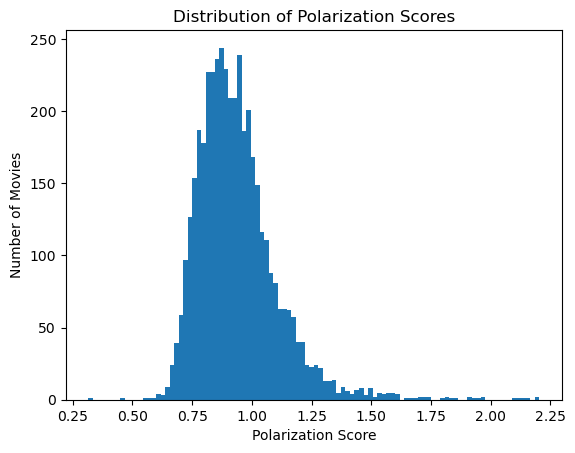

In [41]:
plt.hist(movies['polarization_score'], bins=100)
plt.xlabel('Polarization Score')
plt.ylabel('Number of Movies')
plt.title('Distribution of Polarization Scores')
plt.show()

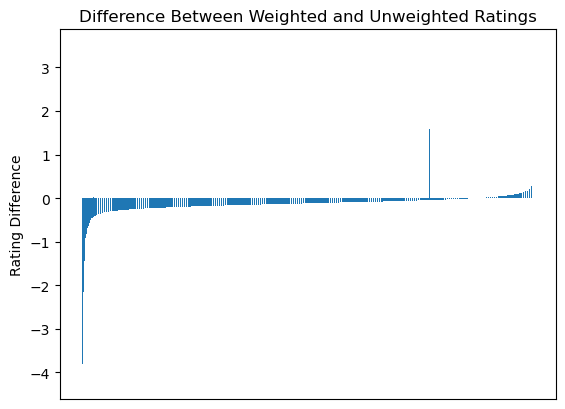

In [42]:
sorted_movies = movies.sort_values('rating_diff', ascending=True)

plt.bar(sorted_movies['title'], sorted_movies['rating_diff'])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.ylabel('Rating Difference')
plt.title('Difference Between Weighted and Unweighted Ratings')
plt.show()

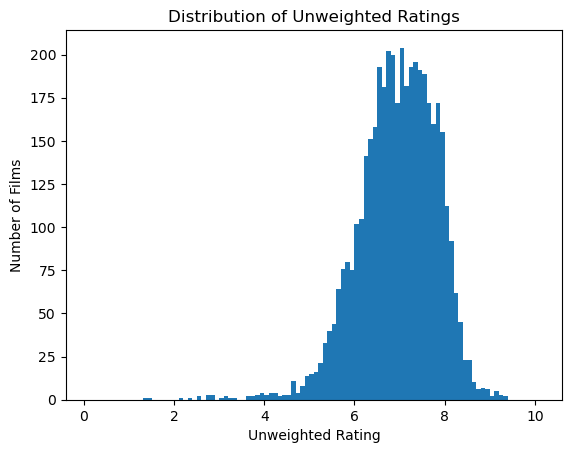

In [43]:
#define bins at each hundredth between 0 and 10
my_bins = [0.1]
for i in range(100):
    my_bins.append(my_bins[i] + 0.1)

plt.hist(movies['unweighted_rating'], bins=my_bins)
plt.xlabel('Unweighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Unweighted Ratings')
plt.show()

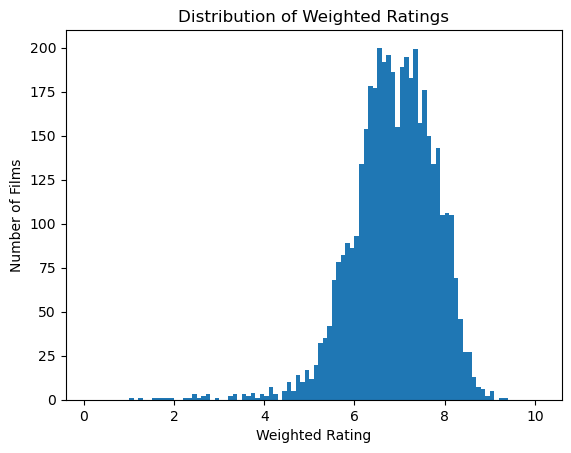

In [44]:
plt.hist(movies['weighted_rating'], bins=my_bins)
plt.xlabel('Weighted Rating')
plt.ylabel('Number of Films')
plt.title('Distribution of Weighted Ratings')
plt.show()

In [ ]:
plt.hist(movies['pct_polarized_votes'], bins=my_bins)
plt.xlabel('Percentage of Polarized Votes')
plt.ylabel('Number of Films')
plt.title('Distribution of Percentages of Polarized Votes')
plt.show()

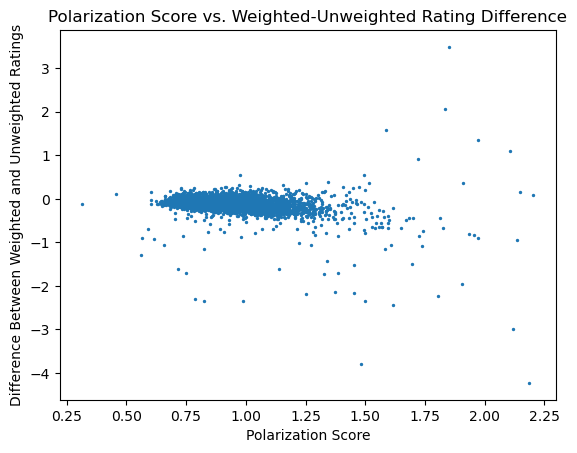

In [45]:
plt.scatter(movies['polarization_score'], movies['rating_diff'], s=2)
plt.ylabel('Difference Between Weighted and Unweighted Ratings')
plt.xlabel('Polarization Score')
plt.title('Polarization Score vs. Weighted-Unweighted Rating Difference')
plt.show()